### Setting up

In [1]:
%load_ext autoreload
%autoreload 1
%aimport trilegal

In [2]:
%matplotlib inline
import trilegal as tg

In [8]:
import healpy as hp
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.table import join

In [3]:
# make sure you have the most recent tables
tg.spark_trilegal_setup(overwrite=True)

Setting up Hive metastore in /astro/users/suberlak/spark-trilegal, by copying from /epyc/projects/trilegal ...


In [4]:
# start the database
spark = tg.spark_start()
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|     tril|      false|
| default|    tril2|      false|
| default|    tril3|      false|
| default|tril_cmds|      false|
+--------+---------+-----------+



### Simple queries

In [5]:
%%time
spark.sql("SELECT count(*) AS count FROM tril2").toPandas()

CPU times: user 57.8 ms, sys: 19.3 ms, total: 77.1 ms
Wall time: 37.9 s


,count
0,20481880003


In [6]:
%%time
data = spark.sql("SELECT * FROM tril2 WHERE gall BETWEEN 0 AND 0.1 AND galb BETWEEN 0 AND 0.1").toPandas()

CPU times: user 290 ms, sys: 1.8 s, total: 2.09 s
Wall time: 22.7 s


In [6]:
#data

Now with a bit of plotting

CPU times: user 401 ms, sys: 64.6 ms, total: 466 ms
Wall time: 4.04 s


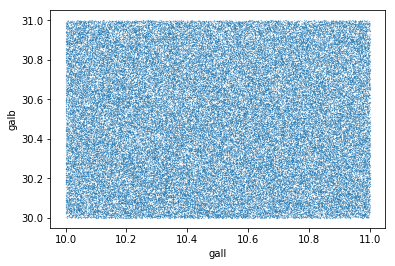

In [8]:
%%time
tril = spark.table('tril2')
pdf = tril.select("gall", "galb").filter("(gall BETWEEN 10 AND 11) AND (galb BETWEEN 30 AND 31)").toPandas()
pdf.plot.scatter(x = 'gall', y = 'galb', s = 0.01)

## Making maps

In [61]:
%%time
import healpy as hp
import pandas as pd

df = (
    spark.table('tril2')
       # .filter("gall BETWEEN 270 AND 280 and galb BETWEEN 20 AND 30")
       # .filter("gmag - rmag BETWEEN 0.2 and 0.4")
    .filter("rmag < 27.5")
)

map_ = df.healpix_count("gall", "galb", NSIDE=64)

CPU times: user 1.69 s, sys: 862 ms, total: 2.55 s
Wall time: 11min 22s


### Make a TRILEGAL table with densities

In [63]:
idx = map_.nonzero()
l,b = hp.pix2ang(64, idx, lonlat=True, nest=True)
counts = map_[idx]  # these are total counts , not counts per sq. deg. 


# For each pixel calculate how many pixels have a higher or equal density 
N_px_greater  = np.zeros_like(counts)

for i in range(len(counts)):
    N_px_greater[i]=np.sum(counts>=counts[i])


# calculate the fraction of pixels that have a higher density (by area)
frac_greater  = N_px_greater /  len(counts)

# Make an AstroPy table with healpix data...

healpix_table = Table([counts,l[0],b[0], N_px_greater, frac_greater], 
                      names=('source_counts','l_deg','b_deg', 'N_px_greater', 
                             'frac_greater'))

# save that table for future use ...
healpix_table.write('trilegal_counts_r_lt_275', format='ascii')

### Make a GALFAST table with densities 

I moved the healpix GALFAST map downloaded from  https://github.com/yoachim/ScratchStuff/tree/master/stellarDensity to epyc : 

    scp starDensity_r_nside_64.npz suberlak@epyc.astro.washington.edu:/data/epyc/users/suberlak/

In [40]:
def make_healpix_table(r_max=24.5):
    ''' A convenience function 
    to read in the MAF simulation data,
    and given the limiting r magnitude, 
    return stellar density per healpixel,
    and the fraction of healpixels with higher
    density , together with ra,dec coord 
    of each healpixel. We use the constraint 
    r < r_max, with  65 magnitude bins between 
    15 and 28 mag every 0.2 mag. 
    
    '''
    # the data consists of 
    # data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
    # data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
    # data['overMaxMask'], which tells where there are more than 1e6 stars 
    data = np.load('starDensity_r_nside_64.npz')


    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    # magnitude bins 
    mag_bins = data['bins'].copy()
    # pixels where there were so many  (1e6 ) stars some were skipped
    mask = data['overMaxMask'].copy()
    # in this simulation none were skipped : 
    # np.sum(mask) = 0

    # select only bins up to r_max - then selecting the final bin will 
    # give us the source count up to depth of r_max mag 
    bright_mag_idx, = np.where(mag_bins<r_max)
    print('Selecting only the source density up \
    to the depth of ', r_max, ' mag')
    faintest_mag_idx = bright_mag_idx[-1]

    # Since the data is already cumulative, just choose the  last bin: 
    # this will have the number of stars up to the faintest magnitude 
    # bin in a given  healpixel 
    starDensity_lt_245 = data['starDensity'][:,faintest_mag_idx]
    # len(starDensity_lt_245) = len(data['starDensity]) = 49142

    # Generate the ra, dec array from healpy
    nside = hp.npix2nside(np.size(mask))
    lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
    dec = np.pi/2-lat

    # only select those healpixels for which we have any simulation data ...
    m = starDensity_lt_245 > 0

    density = starDensity_lt_245[m]
    ra = ra[m]
    dec = dec[m]

    # For each pixel calculate how many pixels have a higher or equal density 
    N_px_greater  = np.zeros_like(density)
    for i in range(len(density)):
        N_px_greater[i]=np.sum(density>=density[i])

    # calculate the fraction of pixels that have a higher density (by area)
    frac_greater  = N_px_greater /  len(density)

    # Make an AstroPy table with healpix data...

    healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                          names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                                 'frac_greater'))
    return healpix_table 

healpix_table = make_healpix_table(r_max=24.5)
healpix_table.write('galfast_counts_r_lt_245', format='ascii')

healpix_table = make_healpix_table(r_max=27.5)
healpix_table.write('galfast_counts_r_lt_275', format='ascii')



Selecting only the source density up     to the depth of  24.5  mag
Selecting only the source density up     to the depth of  27.5  mag


### Functions for calculating counts and making Table.2 from Crowded Fields report

Edited based on Z.'s email from  4/8/18 : 

"Definitions changed slightly so I will repeat them here 
(counts to r<24.5 and to r<27.5 still applies):

1) Main survey

defined by -62 < dec < +2 and without confusion zone

2) confusion zone (as before)

|b| < 10 deg * (1- long / 90) for 0 < long < 90

|b| < 10 deg * (1- (360-long) / 90) for 270 < long < 360

and (new):  Dec < +2 deg.

So for the main survey you could simply count in the band -62 < dec < +2  and 
then subtract the confusion zone counts. Can you please also send me the 
total area of all pixels as a sanity check? "

In [48]:


def density_fmt(x):
    if x < 1e6 : 
        return '%1.f k' % (x*1e-3)
    if x >= 1e6 : 
        return '%1.f mln' % (x*1e-6)

def Billions(x):
    'The two args are the value and tick position'
    return '%1.2f bln' % (x*1e-9)

    
def MillionsBillions(x):
    'The two args are the value and tick position'
    if x < 1e9 : 
        return '%1.2f mln' % (x*1e-6)
    if x >= 1e9 : 
        return '%1.2f bln' % (x*1e-9)
    
def return_stellar_counts(healpix_table, nside=64, counts_table = True,
                         units = 'galactic_deg'):
    ''' A convenience function to take the table of 
    stellar density per healpixel, with 
    ra,dec in rad, and frac_greater,  
    and return :
    
    * N stars in all healpixels
    * N stars in healpixels within top 1%, top 10% density
    * N stars in exclusion zone
    * N stars in the main survey area with / without exclusion zone
    * N stars and area of all healpixels that are  in the main survey area, 
    without exclusion zone, and stellar density lower than rho, with (per sq. deg.) 
    rho = 35,000; 100,000; 200,000, 400,000, 800,000, 1 million, 2 million . 

    NOTE:  
    By default,  the healpixels have the galaxy centered on (l,b) = (0,0). 
    To make it easier to incorporate the confusion zone defined for 
    galaxy centered on (l,b) = (180,0), we shift the coordinates. 

    # Galactic confusion zone : 
    # |b| within the straight
    # lines starting at |b| = 10 deg at l=0 deg, 
    # and dropping linearly to 0 at 
    # l = 90 and l = 270.  
    
    '''
    #print('/n r < %.1f'%)
    px_area_sq_deg = hp.nside2pixarea(nside,degrees=True)
    
    if counts_table : # from TRILEGAL I have counts, from Galfast only source densities... 
        healpix_table['source_density'] = healpix_table['source_counts'] / px_area_sq_deg
    else : # make counts column for GALFAST ... 
        healpix_table['source_counts'] = healpix_table['source_density'] * px_area_sq_deg
        
    # * N stars in all healpixels
    N_all_stars = np.sum(healpix_table['source_counts'])
        
    print('N stars in all healpixels: ', MillionsBillions(N_all_stars))
    
    #* area in all healpixels 
    area_all  = len(healpix_table) * px_area_sq_deg
    print('Total area of all healpixels is %.2f  sq. deg. '% area_all)
    
    #* N stars in healpixels within top 1%, top 10% density
    #for density_percentile in [1,10]:
    #    density = density_percentile / 100.0
    #    select_density  = healpix_table['frac_greater'] < density
    #    if not counts_table : 
    #        N_stars = np.sum(healpix_table[select_density]['source_density'] * px_area_sq_deg)
    #    else:
    #        N_stars = np.sum(healpix_table[select_density]['source_counts'])
    #        
    #    print('N stars in top ', density_percentile,'%',' :', N_stars)
        
    #* N stars in confusion zone
    if units is not 'galactic_deg':
        healpix_coords = SkyCoord(healpix_table['ra_rad'],
                                  healpix_table['dec_rad'], frame='icrs', unit='rad')
        l,b = healpix_coords.galactic.l.deg, healpix_coords.galactic.b.deg
        dec =  healpix_coords.dec.deg
        
    if units is 'galactic_deg':
        l,b = healpix_table['l_deg'], healpix_table['b_deg']
        healpix_coords = SkyCoord(l,
                                  b, frame='galactic', unit='deg')
        dec = healpix_coords.icrs.dec.deg
       

    
    # shift to coords where the galactic center is at (l,b)=(180,0)
    # rather than the traditional (l,b) = (0,0)
    mRight  = l < 180
    mLeft  = l > 180
    l[mLeft] = l[mLeft] - 180
    l[mRight] = l[mRight] + 180

    a = 0.1111111111111111
    m1 = b < -(a * l)  + 30  # l1
    m2 = b >  (a * l)  - 30  # l2
    m3 = b > -(a * l)  + 10  # l3 
    m4 = b <  (a * l)  - 10  # l4
    m_dec = dec < 2  # new constraint

    m_c = m1*m2*m3*m4 * m_dec # inside confusion zone 
    
    N_sources =  np.sum(healpix_table[m_c]['source_counts'])
        
    print('N stars in confusion zone:',MillionsBillions(N_sources))
    
    # the main survey area
    #m_s = (-65 < dec) * (dec<5)
    
    # new definition 
    m_s = (-62 < dec) * (dec < 2)

    #* N stars in the main survey area with / without exclusion zone
    for m, label in zip([m_s, m_s*(~m_c)], ['with', 'without']):
        area = np.sum(m)* px_area_sq_deg
        
        N  =  np.sum(healpix_table[m]['source_counts'])
            
        print('N stars in the main survey area ',label,' conf.zone: ', 
              MillionsBillions(N), ', ', 
              area.round(2),' sq.deg.')
        
        
    # * N stars and area of all healpixels that are  in the main survey area, 
    #  without exclusion zone, and stellar density lower than rho, with (per sq. deg.) 
    #  rho = 35,000; 100,000; 200,000, 400,000, 800,000, 1 million, 2 million . 
    print('N stars and area of healpixels in the main survey area')
    print(' without exclusion zone, stellar density lower than rho : ')
    print('rho   |   area   |   N stars ')
    rhos =[35000, 1e5, 2e5, 3e5,4e5, 6e5,7e5, 8e5, 1e6, 2e6]
    rhos_str = [density_fmt(r) for r in rhos]
    t = Table(data = [rhos_str], names = [r'$\rho$'], dtype=[str])

    t['area'] = 0
    t['N'] = '0000000000'
    t['percWFDltRho'] = '00000000'
    #t['percWFDgtRho'] = 0.0
    t['percConfltRho'] = '00000000'
    #t['percConfgtRho'] = 0.0
    A_WFD = px_area_sq_deg * np.sum(m_s * ~m_c )
    A_conf = px_area_sq_deg * np.sum(m_c)
    
    # find what is the area of WFD 
    for i,rho in enumerate(rhos): # iterate over densities, in units of sources per sq.deg. 
        
        # given rho : 
        
        # 1) what is the area within WFD with density < rho, A_WFD(<rho)
        
        # constrain area : declination
        m1 = m_s
        
        # constrain density
        mltRho = healpix_table['source_density'] < rho
        mgtRho = healpix_table['source_density'] > rho

        # remove exclusion zone 
        m3 = ~m_c

        # combine to make WFD mask 
        mlt = m1 * mltRho * m3
        mgt = m1 * mgtRho * m3
        
        # calculate area in WFD at this density or lower  
        # : number of healpixels times conversion factor 
        A_WFD_ltRho = np.sum(mlt) * px_area_sq_deg
        A_WFD_gtRho = np.sum(mgt) * px_area_sq_deg
        
        t['area'][i]= A_WFD_ltRho.round(2)
        
        # 2) what is the number of sources in that area 
        
        # calculate N sources 
        N_sources = np.sum(healpix_table[mlt]['source_counts'])
        t['N'][i] = Billions(N_sources)
        print(density_fmt(rho), '  ', '%6i'%A_WFD_ltRho, '   ',  Billions(N_sources))
              # '   '   %8i, %6i, %11i'%(rho,  A_WFD_ltRho, N_sources))
        
        # 3) what is the percentage of total WFD area A_WFD(<rho) / A_WFD ? 
        
        # convert area to %of WFD
        t['percWFDltRho'][i] = str((100 * (A_WFD_ltRho / A_WFD)).round(1))+' \%'
       #t['percWFDgtRho'][i] = 100 * (A_WFD_gtRho / A_WFD)
   
        # 4) what is the percentage of confusion zone at that or lower density 
        # A_conf(<rho) / A_conf ? 
        
        # convert area to %of confusion zone 
        A_conf_ltRho = np.sum(m_c * mltRho) * px_area_sq_deg
        A_conf_gtRho = np.sum(m_c * mgtRho) * px_area_sq_deg
        t['percConfltRho'][i] = str((100 * (A_conf_ltRho / A_conf )).round(1))+' \%'
        #t['percConfgtRho'][i] = 100 * (A_conf_gtRho / A_conf )
        
        #print('Area:',area , ', N sources:',N_sources, 'per sq.deg.')
        
  
    return t
    

Making Table 2 from https://dmtn-077.lsst.io/ using TRILEGAL : 

In [49]:
print('r < 24.5')
healpix_table = Table.read('trilegal_counts_r_lt_245', format='ascii')
t1 = return_stellar_counts(healpix_table, nside=64, counts_table = True,
                         units = 'galactic_deg')
print(' ')
print('r < 27.5')
healpix_table = Table.read('trilegal_counts_r_lt_275', format='ascii')
t2 = return_stellar_counts(healpix_table, nside=64, counts_table = True,
                         units = 'galactic_deg')




t1.rename_column('area', 'A(r<24.5)')
t1.rename_column('N', 'N(r<24.5)')
t1.rename_column('percWFDltRho', 'WFD(<24.5)')
t1.rename_column('percConfltRho', 'CZ(<24.5)')
t2.rename_column('area', 'A(r<27.5)')
t2.rename_column('N', 'N(r<27.5)')
t2.rename_column('percWFDltRho', 'WFD(<27.5)')
t2.rename_column('percConfltRho', 'CZ(<27.5)')
                 
t = join(left=t1, right=t2, keys=r'$\rho$')

t.sort('A(r<27.5)')
t[[r'$\rho$', 'A(r<24.5)','A(r<27.5)','N(r<24.5)','N(r<27.5)',
  'WFD(<24.5)','WFD(<27.5)','CZ(<24.5)', 'CZ(<27.5)']].write('trilegal_counts_Table2.txt',
                                                            format = 'latex', overwrite=True)


r < 24.5
N stars in all healpixels:  8.76 bln
Total area of all healpixels is 26921.18  sq. deg. 
N stars in confusion zone: 5.64 bln
N stars in the main survey area  with  conf.zone:  7.25 bln ,  18928.59  sq.deg.
N stars in the main survey area  without  conf.zone:  1.75 bln ,  17571.45  sq.deg.
N stars and area of healpixels in the main survey area
 without exclusion zone, stellar density lower than rho : 
rho   |   area   |   N stars 
35 k      9401     0.15 bln
100 k     13113     0.38 bln
200 k     15073     0.65 bln
300 k     15943     0.87 bln
400 k     16486     1.06 bln
600 k     17065     1.33 bln
700 k     17221     1.44 bln
800 k     17351     1.53 bln
1 mln     17492     1.66 bln
2 mln     17571     1.75 bln
 
r < 27.5
N stars in all healpixels:  19.82 bln
Total area of all healpixels is 26921.18  sq. deg. 
N stars in confusion zone: 12.51 bln
N stars in the main survey area  with  conf.zone:  16.03 bln ,  18928.59  sq.deg.
N stars in the main survey area  without  conf.z

Note:  now need to copy that file to local LSST_crowded_fields/report/   : 

    scp suberlak@epyc.astro.washington.edu:/data/epyc/users/suberlak/trilegal_counts_Table2.txt .

Making Table 2 from https://dmtn-077.lsst.io/  using GALFAST data (with new definition of the Main Survey ... )

In [50]:
print('r < 24.5')
healpix_table = Table.read('galfast_counts_r_lt_245', format='ascii')
t1 = return_stellar_counts(healpix_table, nside=64, counts_table = False,
                         units = 'radians')
print(' ')
print('r < 27.5')
healpix_table = Table.read('galfast_counts_r_lt_275', format='ascii')
t2 = return_stellar_counts(healpix_table, nside=64, counts_table = False,
                         units = 'radians')




t1.rename_column('area', 'A(r<24.5)')
t1.rename_column('N', 'N(r<24.5)')
t1.rename_column('percWFDltRho', 'WFD(<24.5)')
t1.rename_column('percConfltRho', 'CZ(<24.5)')
t2.rename_column('area', 'A(r<27.5)')
t2.rename_column('N', 'N(r<27.5)')
t2.rename_column('percWFDltRho', 'WFD(<27.5)')
t2.rename_column('percConfltRho', 'CZ(<27.5)')
                 
t = join(left=t1, right=t2, keys=r'$\rho$')

t.sort('A(r<27.5)')
t[[r'$\rho$', 'A(r<24.5)','A(r<27.5)','N(r<24.5)','N(r<27.5)',
  'WFD(<24.5)','WFD(<27.5)','CZ(<24.5)', 'CZ(<27.5)']].write('trilegal_counts_Table2.txt',
                                                            format = 'latex', overwrite=True)


r < 24.5
N stars in all healpixels:  3.76 bln
Total area of all healpixels is 32551.16  sq. deg. 
N stars in confusion zone: 2.04 bln
N stars in the main survey area  with  conf.zone:  3.02 bln ,  19018.39  sq.deg.
N stars in the main survey area  without  conf.zone:  1.03 bln ,  17649.51  sq.deg.
N stars and area of healpixels in the main survey area
 without exclusion zone, stellar density lower than rho : 
rho   |   area   |   N stars 
35 k     11949     0.15 bln
100 k     14978     0.33 bln
200 k     16301     0.52 bln
300 k     16864     0.66 bln
400 k     17182     0.77 bln
600 k     17493     0.92 bln
700 k     17568     0.97 bln
800 k     17618     1.00 bln
1 mln     17649     1.03 bln
2 mln     17649     1.03 bln
 
r < 27.5
N stars in all healpixels:  8.50 bln
Total area of all healpixels is 32551.16  sq. deg. 
N stars in confusion zone: 5.05 bln
N stars in the main survey area  with  conf.zone:  6.97 bln ,  19018.39  sq.deg.
N stars in the main survey area  without  conf.zone

In [47]:
healpix_table

source_density,ra_rad,dec_rad,N_px_greater,frac_greater
float64,float64,float64,float64,float64
10476.0,0.0,0.6100600350363932,24429.0,0.6298731435643564
11916.0,0.02454369260617026,0.6100600350363932,22679.0,0.5847514438943895
11160.0,0.04908738521234052,0.6100600350363932,23582.0,0.6080342409240924
9756.0,0.07363107781851078,0.6100600350363932,25488.0,0.6571782178217822
10044.0,0.09817477042468103,0.6100600350363932,25058.0,0.6460911716171617
9756.0,0.1227184630308513,0.6100600350363932,25488.0,0.6571782178217822
10908.0,0.14726215563702155,0.6100600350363932,23901.0,0.6162592821782178
9684.0,0.1718058482431918,0.6100600350363932,25606.0,0.6602207095709571
9288.0,0.19634954084936207,0.6100600350363932,26169.0,0.674737004950495


### New TRILEGAL counts .

In [11]:
healpix_table = Table.read('trilegal_counts_r_lt_245', format='ascii')
t1 = return_stellar_counts(healpix_table, nside=64, counts_table = True,
                         units = 'galactic_deg')


healpix_table = Table.read('trilegal_counts_r_lt_275', format='ascii')
t2 = return_stellar_counts(healpix_table, nside=64, counts_table = True,
                         units = 'galactic_deg')


N stars in all healpixels:  8760300089.0
Total area of all healpixels is  26921.182963793384  sq. deg. 
N stars in confusion zone: 5641823230.0
N stars in the main survey area  with  conf.zone:  7247084222.0 ,  18928.589580447446  sq.deg.
N stars in the main survey area  without  conf.zone:  1747515715.0 ,  17571.45175614099  sq.deg.
N stars and area of healpixels in the main survey area
 without exclusion zone, stellar density lower than rho
rho   |   area   |   N stars 
   35000,   9401,   152504729
  100000,  13113,   376736836
  200000,  15073,   654643909
  300000,  15943,   867351575
  400000,  16486,  1055103360
  600000,  17065,  1334387590
  700000,  17221,  1435005692
  800000,  17351,  1532493172
 1000000,  17492,  1656999469
 2000000,  17571,  1747515715
N stars in all healpixels:  19819220371.0
Total area of all healpixels is  26921.182963793384  sq. deg. 
N stars in confusion zone: 12505024027.0
N stars in the main survey area  with  conf.zone:  16034858245.0 ,  18928.589

### Plot a map of  densities for TRILEGAL  with exclusion zone contoured

In [37]:
#healpix_table, nside = make_healpix_table(24.5)
healpix_coords = SkyCoord(healpix_table['l_deg'], 
                          healpix_table['b_deg'], 
                          frame='galactic', 
                          unit='deg')

# Define the tick formatter to have degrees ....
from matplotlib.ticker import FuncFormatter
import matplotlib
import matplotlib.pyplot as plt 
rcParams = matplotlib.rcParams
#from astroML.plotting import setup_text_plots
#setup_text_plots( usetex=True)

def degrees( x, pos=None):
    """
    Used to format the theta tick labels.  Converts the native
    unit of radians into degrees and adds a degree symbol.
    """
    degrees = (x / np.pi) * 180.0
    degrees = np.round(degrees)
    if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
        return r"$%0.0f^\circ$" % degrees
    else:
        return "%0.0f\u00b0" % degrees
    
%matplotlib inline

# express the MAF healpixel coords in galactic 
# coords,  in degrees 
longitude = healpix_coords.galactic.l.deg
latitude  = healpix_coords.galactic.b.deg

# convert degrees to radians
ind = longitude > 180
longitude[ind] -=360    # scale conversion to [-180, 180]
longitude = - longitude    # reverse the scale: East to the left
org = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)

# color by the fraction of pixels at greater density (or 1 - that)
z = healpix_table['frac_greater']

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow',
                    )

# plot the background too
imge = ax.scatter(np.radians(longitude),np.radians(latitude),  alpha=0.4,
                  s=14, c=1-z,
                  zorder=-5)  

# Loop over the brackets : 
for density in [ 0.05,0.20,0.4]:
    m = ((density-0.01) < z )* (z<(density+0.01))
    # convert degrees to radians
    ax.scatter(np.radians(longitude[m]),np.radians(latitude[m]), 
                      alpha=0.4,s=14,
                      zorder=-5, label=str(int(100*density))+'%')  
    
# add a legend for densities 
plt.legend(fontsize=14, bbox_to_anchor=(0.85,0.7),
             fancybox=True,handletextpad=-0.5)


# plot the confusion zone 
xs = [0,-90,0,90,0]
ys = [10,0,-10,0,10]
for i in range(len(xs)-1):
    x0,y0 = xs[i],ys[i]
    x1,y1  = xs[i+1],ys[i+1]
    ax.plot(np.radians([x0,x1]), 
            np.radians([y0,y1]),
            lw=4,ls='--',c='red')
    
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Galactic Longitude,l ')
ax.set_ylabel('Galactic Latitude, b')
ax.grid(True)
plt.colorbar(imge, label='fraction at lower density')
plt.savefig('TRILEGAL_densities_lt_245.png', 
            bbox_inches='tight')

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/projections/geo.py:485: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


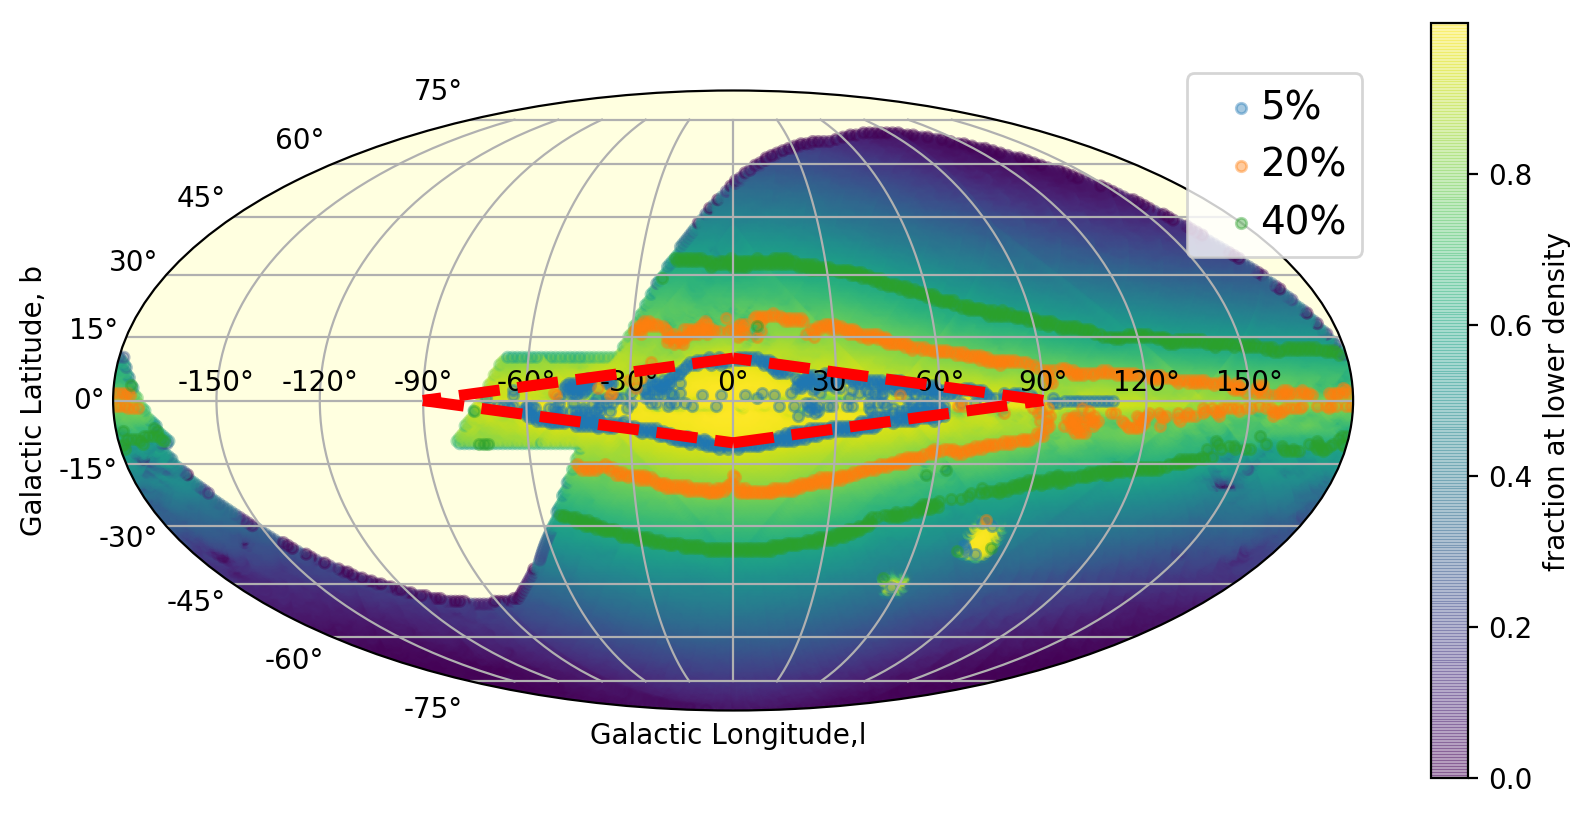

In [44]:
pwd

'/data/epyc/users/suberlak'

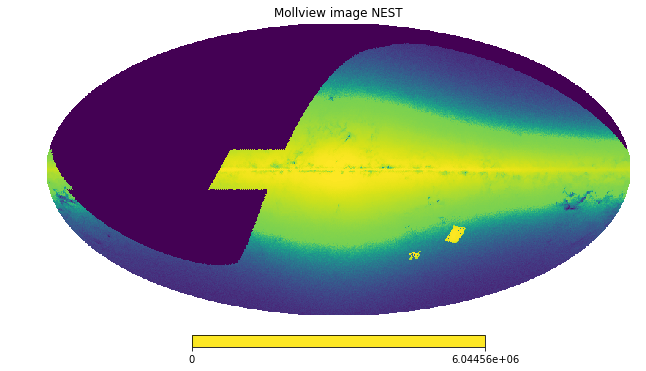

In [28]:
hp.mollview(map_, title="Mollview image NEST", nest=True, norm='hist')

In [19]:
spark.sparkContext.getConf().getAll()

[('spark.local.dir', '/epyc/ssd/spark-temp'),
 ('spark.sql.execution.arrow.enabled', 'true'),
 ('spark.master', 'local[64]'),
 ('spark.executor.id', 'driver'),
 ('spark.memory.offHeap.enabled', 'true'),
 ('spark.driver.memory', '128G'),
 ('spark.app.name', "Mario's Sparky Stuff"),
 ('spark.sql.warehouse.dir', '/epyc/projects/trilegal/spark-warehouse'),
 ('spark.memory.offHeap.size', '256G'),
 ('spark.driver.host', 'epyc.astro.washington.edu'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.driver.extraJavaOptions',
  '-Dderby.system.home=/astro/users/mjuric/spark-trilegal'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1522398834582'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.maxResultSize', '16G'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '35275')]

In [35]:
import pyspark.sql.functions
df = spark.table("tril2").select('gall', 'galb', 'hhp', 'gmag').where("gall BETWEEN 270 AND 272 and galb BETWEEN 20 AND 22")
df = df.withColumn('magbin', pyspark.sql.functions.floor(df['gmag']))
df = df.groupby('hhp', 'magbin').sum()
df.explain()

== Physical Plan ==
*(1) HashAggregate(keys=[hhp#61L, magbin#1632L], functions=[sum(gall#17), sum(galb#18), sum(hhp#61L), sum(cast(gmag#47 as double)), sum(magbin#1632L)])
+- *(1) HashAggregate(keys=[hhp#61L, magbin#1632L], functions=[partial_sum(gall#17), partial_sum(galb#18), partial_sum(hhp#61L), partial_sum(cast(gmag#47 as double)), partial_sum(magbin#1632L)])
   +- *(1) Project [gall#17, galb#18, hhp#61L, gmag#47, FLOOR(cast(gmag#47 as double)) AS magbin#1632L]
      +- *(1) Filter (((((isnotnull(galb#18) && isnotnull(gall#17)) && (gall#17 >= 270.0)) && (gall#17 <= 272.0)) && (galb#18 >= 20.0)) && (galb#18 <= 22.0))
         +- *(1) FileScan parquet default.tril2[gall#17,galb#18,gmag#47,hhp#61L] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/data/epyc/projects/trilegal/spark-warehouse/tril2], PartitionFilters: [], PushedFilters: [IsNotNull(galb), IsNotNull(gall), GreaterThanOrEqual(gall,270.0), LessThanOrEqual(gall,272.0), G..., ReadSchema: struct<gall:double,ga

In [22]:
2.3//1

2.0

In [57]:
hp.nside2resol(2**28, arcmin=True)*60*1000

0.786320437275102

In [54]:
hp.nside2order(2**20)

20

In [65]:
hp.nside2npix(1024)*8*16/1024/1024/1024

1.5